In [9]:
# PDE: -u_xx - u_yy = f(x, y)  on  [0,1]^2
# BCs:
#   u(x, 0) = 0
#   n·∇u = 0  at x=0 and x=1   (Neumann)
#   u(x, 1) = cos(π x)

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sp
import scipy.sparse.linalg as sla

In [11]:
def u_exact(x,y):
    return (np.sinh(np.pi*y)/np.sinh(np.pi)) * np.cos(np.pi*x)

def plot_field(x,y,u):
    fig, ax = plt.subplots(figsize=(6, 5))
    c = ax.pcolormesh(x, y, u, shading='auto', cmap='plasma')
    ax.set_aspect('equal')
    ax.set_axis_off()
    cb = fig.colorbar(c, ax=ax)
    cb.set_label("u")
    plt.savefig("u_fd.png")
    plt.show()

def gnorm(u, hx, hy):
    return np.sqrt(hx * hy * np.sum(u**2))


In [12]:
def laplace_finite_difference(nx, ny, hx , hy):

    N = ny * nx

    alpha = 1 / hx ** 2
    beta = 1 / hy ** 2

    def f_func(x, y):
        return 0.0

    A = sp.lil_matrix((N, N))
    b = np.zeros(N)

    # Fill matrix A and vector b
    for i in range(ny):
        for j in range(nx):
            k = i * nx + j
            b[k] = f_func(x1d[j], y1d[i])

            # --- x-direction discretization (only for interior nodes) ---
            if j != 0 and j != nx - 1:
                A[k, k - 1] += -alpha
                A[k, k] += 2 * alpha
                A[k, k + 1] += -alpha

            #  --- y-direction discretization (only for interior nodes) ---
            if i != 0 and i != ny - 1:
                A[k, k - nx] += -beta
                A[k, k] += 2 * beta
                A[k, k + nx] += -beta

    # Apply Dirichlet boundary conditions in the y-direction (vectorized)
    bottom = np.arange(nx)  # i = 0 boundary indices
    top = np.arange((ny - 1) * nx, ny * nx)  # i = ny-1 boundary indices

    # Bottom boundary: u(x, 0) = 0
    A[bottom, :] = 0
    A[bottom, bottom] = 1.0
    b[bottom] = 0.0

    # Top boundary: u(x, 1) = sin(pi*x)
    A[top, :] = 0
    A[top, top] = 1.0
    b[top] = np.sin(np.pi * x1d)

    # Apply Dirichlet boundary conditions in the x-direction (vectorized)
    left = np.arange(0, N, nx)  # j = 0 boundary indices
    right = np.arange(nx - 1, N, nx)  # j = nx-1 boundary indices

    # Left boundary: u(0, y) = 0
    A[left, :] = 0
    A[left, left] = 1.0
    b[left] = 0.0

    # Right boundary: u(1, y) = 0
    A[right, :] = 0
    A[right, right] = 1.0
    b[right] = 0.0

    # Solve the linear system
    u_vec = sla.spsolve(A.tocsr(), b)
    u = u_vec.reshape((ny, nx))



    # Return necessary variables for further analysis
    return A, b, u


Mesh Statistics
Total Nodes: 256
nx = 16 and ny = 16
hx = 0.06250 and hy = 0.06250



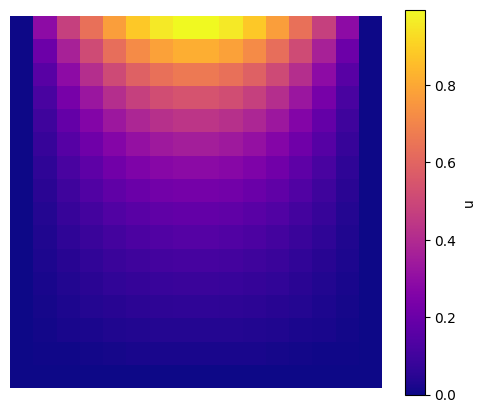

Mesh Statistics
Total Nodes: 1024
nx = 32 and ny = 32
hx = 0.03125 and hy = 0.03125



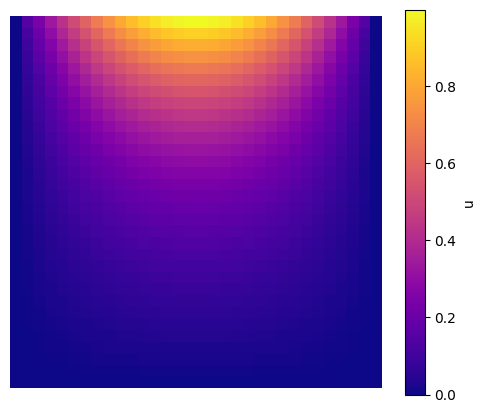

Mesh Statistics
Total Nodes: 4096
nx = 64 and ny = 64
hx = 0.01562 and hy = 0.01562



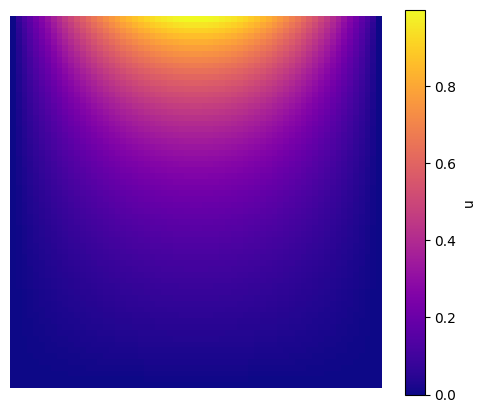

Mesh Statistics
Total Nodes: 16384
nx = 128 and ny = 128
hx = 0.00781 and hy = 0.00781



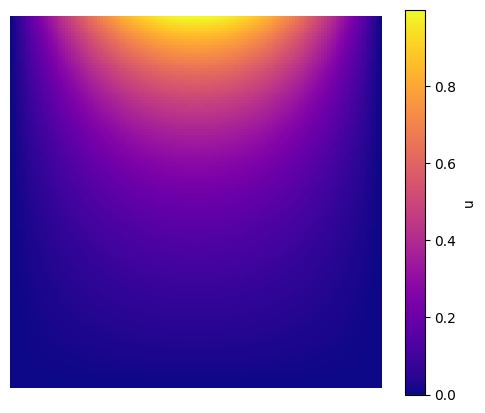

Truncation Errors and Empirical Order:
Grid size |    hx    | Truncation Error
       16 | 0.06250 | 2.87094e-14
       32 | 0.03125 | 1.49059e-13
       64 | 0.01562 | 6.13584e-13
      128 | 0.00781 | 2.64484e-12
Order between grid 16 and 32: -2.38
Order between grid 32 and 64: -2.04
Order between grid 64 and 128: -2.11

Stability (Norm of A^{-1})):
Grid size |    hx    | Norm of A^-1
       16 | 0.06250 | 8.72377e+00
       32 | 0.03125 | 1.30626e+01
       64 | 0.01562 | 1.93456e+01
      128 | 0.00781 | 2.84635e+01

Convergence Errors and Empirical Order:
Grid size |    hx    | Convergence Error
       16 | 0.06250 | 4.08924e-01
       32 | 0.03125 | 4.01869e-01
       64 | 0.01562 | 3.98397e-01
      128 | 0.00781 | 3.96677e-01
Order between grid 16 and 32: 0.03
Order between grid 32 and 64: 0.01
Order between grid 64 and 128: 0.01


In [13]:
import numpy as np
import matplotlib.pyplot as plt

# Define grid sizes for refinement study
grid_sizes = [16, 32, 64, 128]
h_vals = []
trunc_errors = []
conv_errors = []
stab_norms = []

for nx in grid_sizes:
    ny = nx  # use square grids for simplicity
    # Create grid with cell-centered points
    x1d, hx = np.linspace(0, 1, nx, endpoint=False, retstep=True)
    y1d, hy = np.linspace(0, 1, ny, endpoint=False, retstep=True)
    x1d += hx / 2
    y1d += hy / 2
    x, y = np.meshgrid(x1d, y1d)

    # Print mesh statistics
    print("Mesh Statistics")
    print(f"Total Nodes: {x.size}")
    print(f"nx = {nx} and ny = {ny}")
    print(f"hx = {hx:.5f} and hy = {hy:.5f}\n")

    # Compute finite difference system and solution
    A, b, u = laplace_finite_difference(nx=nx, ny=ny, hx=hx, hy=hy)
    U = u_exact(x, y)

    # Plot the numerical solution (optional)
    plot_field(x, y, u)

    # Compute error metrics:
    # 1. Truncation error: residual of the discrete operator
    F_ex = (A @ u.flatten() - b).reshape(u.shape)
    trunc_err = gnorm(F_ex, hx, hy)
    trunc_errors.append(trunc_err)

    # 2. Stability: norm of the inverse of A
    A_dense = A.toarray()
    A_inv = np.linalg.inv(A_dense)
    stab_norm = np.linalg.norm(A_inv)
    stab_norms.append(stab_norm)

    # 3. Convergence error: difference between numerical and exact solution
    conv_err = gnorm(U - u, hx, hy)
    conv_errors.append(conv_err)

    h_vals.append(hx)

print("Truncation Errors and Empirical Order:")
print("Grid size |    hx    | Truncation Error")
for i, nx in enumerate(grid_sizes):
    print(f"{nx:9d} | {h_vals[i]:.5f} | {trunc_errors[i]:.5e}")

orders_trunc = []
for i in range(1, len(grid_sizes)):
    order = np.log(trunc_errors[i - 1] / trunc_errors[i]) / np.log(2)
    orders_trunc.append(order)
    print(f"Order between grid {grid_sizes[i - 1]} and {grid_sizes[i]}: {order:.2f}")

print("\nStability (Norm of A^{-1})):")
print("Grid size |    hx    | Norm of A^-1")
for i, nx in enumerate(grid_sizes):
    print(f"{nx:9d} | {h_vals[i]:.5f} | {stab_norms[i]:.5e}")

print("\nConvergence Errors and Empirical Order:")
print("Grid size |    hx    | Convergence Error")
for i, nx in enumerate(grid_sizes):
    print(f"{nx:9d} | {h_vals[i]:.5f} | {conv_errors[i]:.5e}")

orders_conv = []
for i in range(1, len(grid_sizes)):
    order = np.log(conv_errors[i - 1] / conv_errors[i]) / np.log(2)
    orders_conv.append(order)
    print(f"Order between grid {grid_sizes[i - 1]} and {grid_sizes[i]}: {order:.2f}")
